### Preface

В данной работе я тестирую несколько видов фичей: 

1) просто полученные из таблицы или модифакции данных из таблиц (взятие логарифма и тд)

2) моментум в объеме

3) исследование потоков объема из нижнего уровня бид/аск заявок в верхний

Немного подробнее про 3 идею. Я формулирую следующую гипотезу:
Допустим, что наблюдается большой объем заявок на покупку, таким образом, что объем ask0 будет явно меньше чем bid0 bid1 ... . Т.е., происходит давление спроса на предложение. Тогда, продавцам может быть выгодно переставить свои объемы на уровни выше (ask1, ask2, ask3, ask4), в надежде на то, что цена пойдет выше и они смогут продать по цене выше. Таким образом, гипотетически, спред может увеличиться (предполагается, в таком случае, что цена аска будет расти быстрее бида). Поэтому, мы можем ожидать переток объема из ask0/bid0 в ask[1:4]/bid[1:4] (в зависимости от того кто "давит")

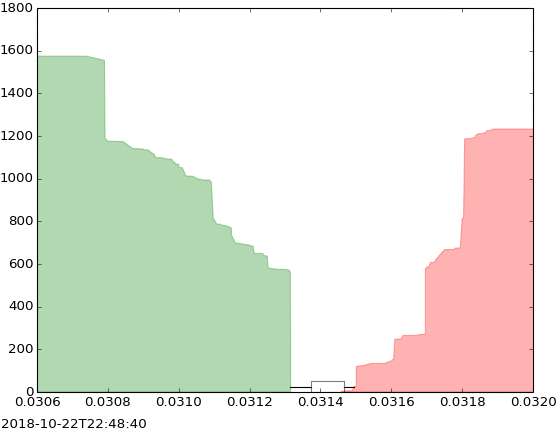




Далее, я рассматриваю фичи, у которых найдется такая область определения, где вероятность P(1 | x) будет больше 10%.

Метрика качества (по заданию) roc_auc_score. Полученный результат ~ 0.9

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import skew
import seaborn as sns

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [2]:
train_data = pd.read_csv('train.csv')


In [3]:
test_data = pd.read_csv('test.csv')


In [4]:
data = train_data
train_data

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,...,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
0,108,276,224,196,195,132,181,253,207,185,...,276,224,196,195,136,181,253,207,185,0
1,47,132,197,236,188,81,146,193,169,192,...,132,197,236,188,81,146,193,169,192,0
2,93,172,193,226,232,33,128,168,145,140,...,172,193,226,232,33,128,168,145,140,0
3,62,104,169,188,140,75,165,151,206,105,...,104,169,188,140,81,165,151,206,105,0
4,40,43,87,110,99,11,66,77,155,364,...,43,87,110,99,11,66,77,153,364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186585,82,170,163,162,160,20,121,143,152,93,...,170,163,162,160,18,121,143,152,93,0
186586,32,176,214,299,265,261,235,232,229,238,...,176,215,299,265,261,235,232,229,238,0
186587,95,226,159,203,137,54,143,155,133,194,...,226,159,203,137,53,143,155,133,194,0
186588,140,223,297,316,561,61,211,224,254,244,...,223,297,316,561,61,211,224,254,244,0


In [5]:
def add_feature(feature, name):
    train_data[name] = feature
    print(train_data.columns)
    
def del_feature(name):
    del train_data[name]
    

def plot_feature(name):
    sns.lmplot(name, 'Y', train_data, 'Y', fit_reg=False)
    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    plt.show()
    
def plot_2(data1, data2):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('1', color=color)
    ax1.plot(data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('0', color=color)  # we already handled the x-label with ax1
    ax2.plot(data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [6]:
train_data['Y'].value_counts()

0    184676
1      1914
Name: Y, dtype: int64

#### Табличные фичи

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0'],
      dtype='object')


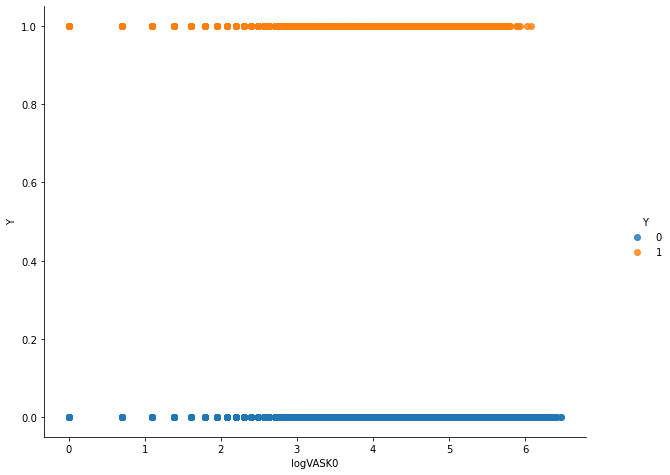

In [7]:
add_feature(np.log(data['VASK0']), 'logVASK0')
plot_feature('logVASK0');

In [8]:
t = data[data['logVASK0'] < 1]['Y']
sum(t)/len(t)

0.13247049866768176

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0'],
      dtype='object')


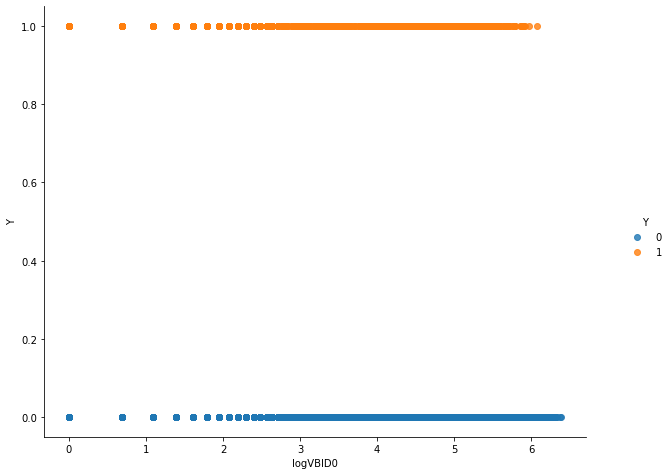

In [9]:
add_feature(np.log(data['VBID0']), 'logVBID0')
plot_feature('logVBID0')

In [10]:
t = data[data['logVBID0'] < 1]['Y']
sum(t)/len(t)

0.12025316455696203

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV'],
      dtype='object')


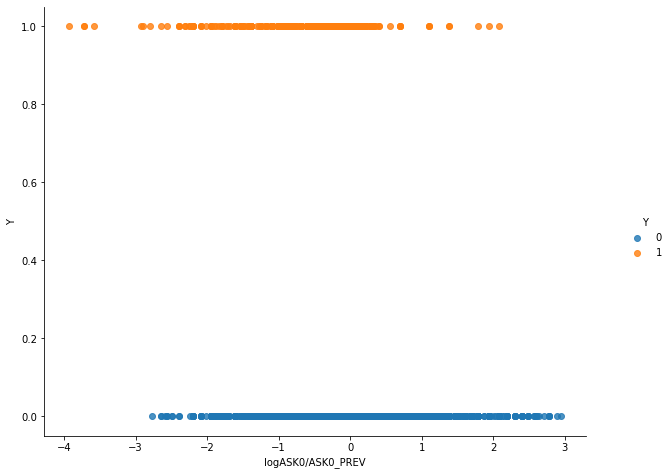

In [11]:
add_feature(np.log(data['VASK0']/data['VASK0_PREV']), 'logASK0/ASK0_PREV')
plot_feature('logASK0/ASK0_PREV');

In [12]:
t = data[data['logASK0/ASK0_PREV'] < -2]['Y']
sum(t)/len(t)

0.5102040816326531

In [13]:
#add_feature(np.log(data['VBID1']/data['VBID0_PREV']), 'logBID0/BID0_PREV')
#plot_feature('logBID0/BID0_PREV')

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV'],
      dtype='object')


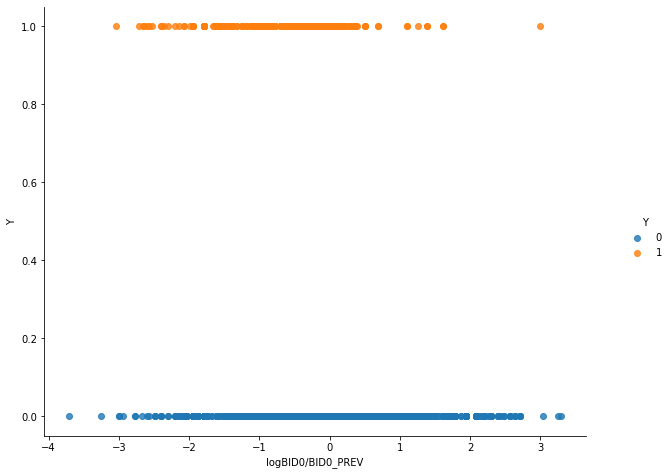

In [14]:
add_feature(np.log(data['VBID0']/data['VBID0_PREV']), 'logBID0/BID0_PREV')
plot_feature('logBID0/BID0_PREV')

In [15]:
t = data[data['logBID0/BID0_PREV'] < -2]['Y']
sum(t)/len(t)

0.30612244897959184

### Моментумы

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0'],
      dtype='object')


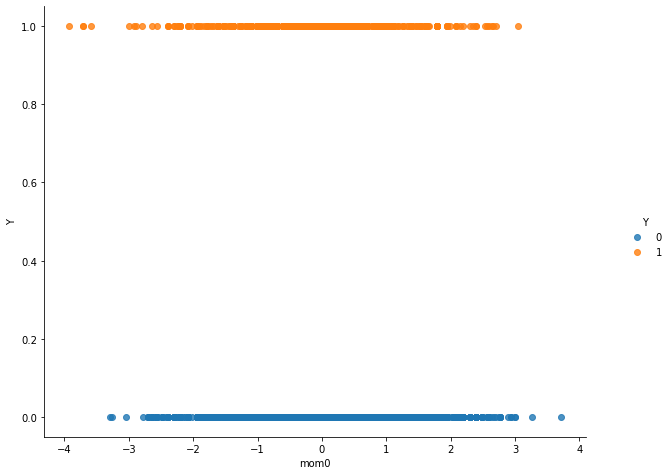

In [16]:
add_feature(np.log(data['VASK0']/data['VASK0_PREV'])
            -
            np.log(data['VBID0']/data['VBID0_PREV'])
            , 'mom0')
plot_feature('mom0')

In [17]:
t = data[data['mom0'] < -2]['Y']
sum(t)/len(t)

0.25

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1'],
      dtype='object')


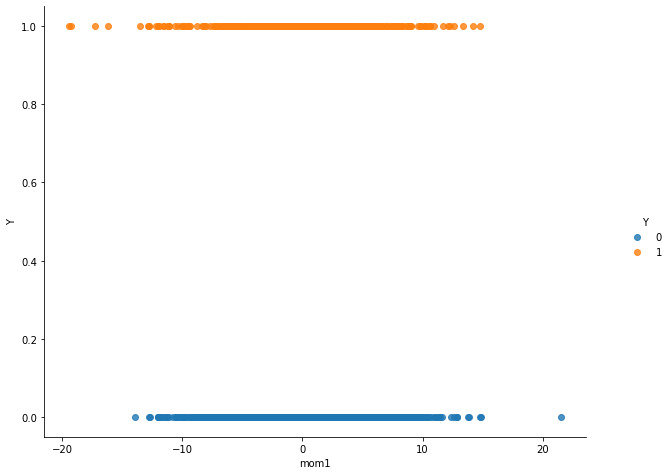

In [18]:
add_feature(np.log(data['VASK0']/data['VASK0_PREV']) * np.log(data['VASK1']/data['VASK0'])
            -
            np.log(data['VBID0']/data['VBID0_PREV']) * np.log(data['VBID1']/data['VBID0'])
            , 'mom1')
plot_feature('mom1')

In [19]:
t = data[data['mom1'] < -10]['Y']
sum(t)/len(t)

0.4883720930232558

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2'],
      dtype='object')


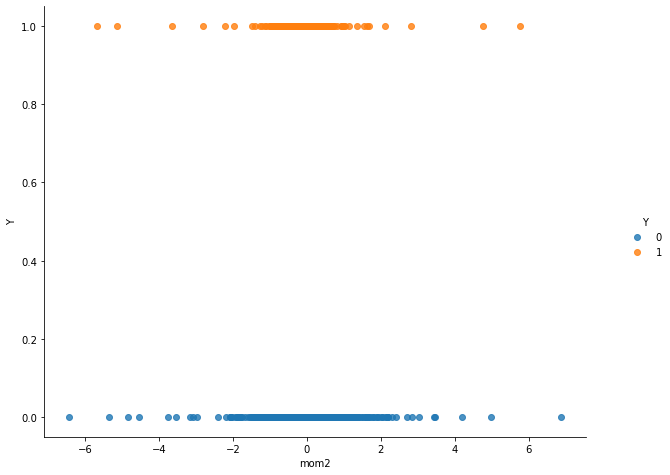

In [20]:
add_feature(np.log(data['VASK0']/data['VASK0_PREV']) * np.log(data['VASK1']/data['VASK0'])*
            np.log(data['VASK2']/data['VASK1'])*np.log(data['VASK3']/data['VASK2'])
            -
            np.log(data['VBID0']/data['VBID0_PREV']) * np.log(data['VBID1']/data['VBID0'])*
            np.log(data['VBID2']/data['VBID1'])*np.log(data['VBID3']/data['VBID2'])
            , 'mom2')
plot_feature('mom2')

In [21]:
t = data[data['mom2'] > 4]['Y']
sum(t)/len(t)

0.4

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2',
       'mom3'],
      dtype='object')


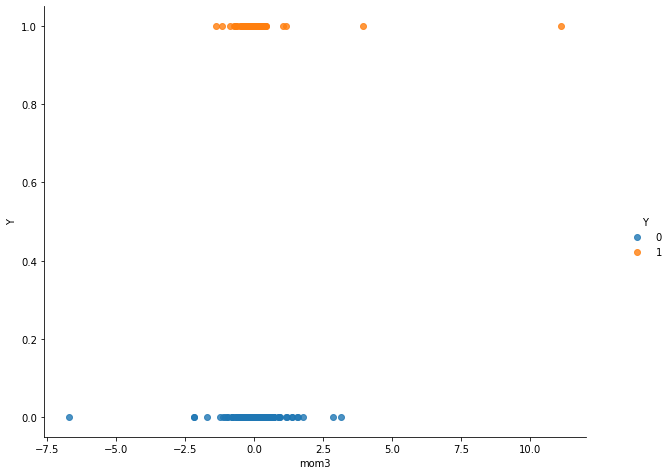

In [22]:
add_feature(np.log(data['VASK0']/data['VASK0_PREV']) * np.log(data['VASK1']/data['VASK0'])*
            np.log(data['VASK2']/data['VASK1'])*np.log(data['VASK3']/data['VASK2'])*
            np.log(data['VASK4']/data['VASK3'])
            
            -
            
            np.log(data['VBID0']/data['VBID0_PREV']) * np.log(data['VBID1']/data['VBID0'])*
            np.log(data['VBID2']/data['VBID1'])*np.log(data['VBID3']/data['VBID2'])*np.log(data['VBID4']/data['VBID3'])
            , 'mom3')
plot_feature('mom3')

In [23]:
data[['mom0', 'mom1', 'mom2', 'mom3']].corr()

,mom0,mom1,mom2,mom3
mom0,1.000000,0.936666,-0.119564,-0.092264
mom1,0.936666,1.000000,-0.136824,-0.082998
mom2,-0.119564,-0.136824,1.000000,-0.025919
mom3,-0.092264,-0.082998,-0.025919,1.000000


Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2',
       'mom3', 'std'],
      dtype='object')


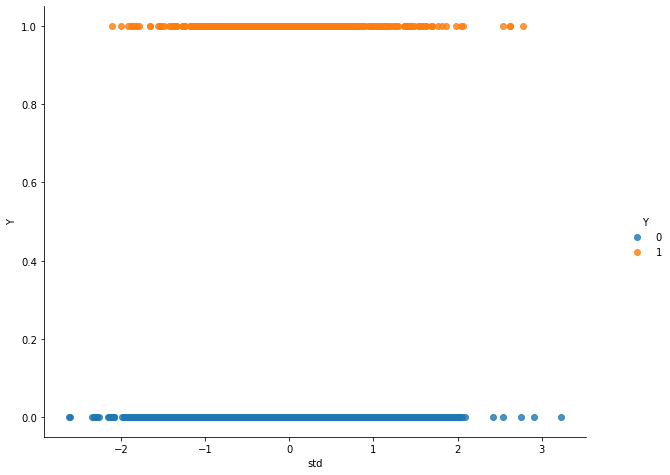

In [24]:
add_feature(np.log(data['VASK0']/data['VASK0_PREV']).rolling(2).std()
            - np.log(data['VBID0']/data['VBID0_PREV']).rolling(2).std(), 'std')
plot_feature('std')

In [25]:
t = data[data['std'] > 1.35]['Y']
sum(t)/len(t)

0.11075949367088607

# Flows

####### credit https://medium.com/@a.botsula/using-kalman-filters-to-derive-predictive-factors-from-limit-order-book-data-2242eef97d80

In [26]:
fl0 = np.log(data['VASK0']) - np.log(data[['VASK1', 'VASK2', 'VASK3', 'VASK4']].sum(axis = 1))

In [27]:

flbtw = (np.log(data[['VASK1', 'VASK2', 'VASK3', 'VASK4']]) - np.log((data[['VASK1_PREV', 'VASK2_PREV', 'VASK3_PREV', 'VASK4_PREV']]).shift(1))).fillna(0).sum(axis = 1)

In [28]:
vol= np.log(data[['VASK1', 'VASK2', 'VASK3', 'VASK4']].sum(axis = 1))

In [29]:
add_feature(vol + flbtw - fl0, 'ask_flow')

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2',
       'mom3', 'std', 'ask_flow'],
      dtype='object')


In [30]:
fl0 = np.log(data['VBID0']) - np.log(data[['VBID1', 'VBID3', 'VBID4']].sum(axis = 1))

In [31]:
flbt = (np.log(data[['VBID1', 'VBID2', 'VBID3', 'VBID4']]) - np.log((data[['VBID1_PREV', 'VBID2_PREV', 'VBID3_PREV', 'VBID4_PREV']]).shift(1))).fillna(0).sum(axis = 1)

#(data[['VBID1', 'VBID3', 'VBID4']] - np.log(data[['VBID1_PREV', 'VBID3_PREV', 'VBID4_PREV']].shift(1)).fillna(0).sum(axis = 1)/

In [32]:
vol= np.log(data[['VBID1', 'VBID2', 'VBID3', 'VBID4']].sum(axis = 1))

In [33]:
add_feature(vol + flbt - fl0, 'bid_flow')

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2',
       'mom3', 'std', 'ask_flow', 'bid_flow'],
      dtype='object')


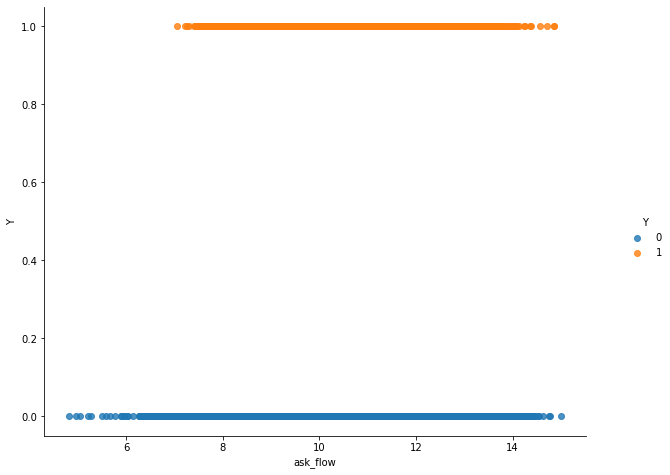

In [34]:
plot_feature('ask_flow')

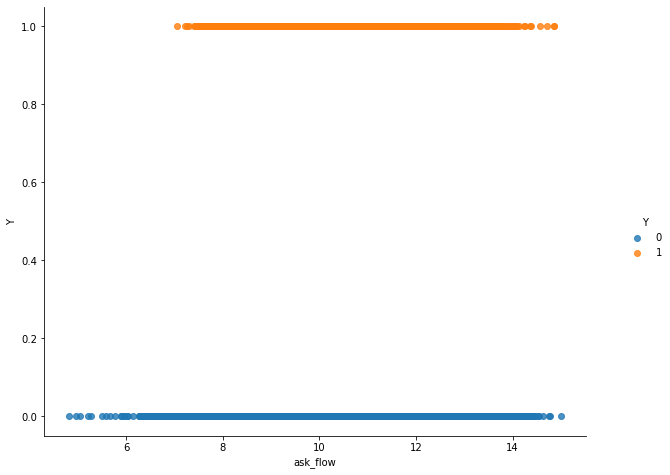

In [35]:
plot_feature('ask_flow')

In [36]:
t = data[data['ask_flow'] < 7.3]['Y']
sum(t)/len(t)

0.007827788649706457

In [37]:
t = data[data['ask_flow'] > 13]['Y']
sum(t)/len(t)

0.13858424725822532

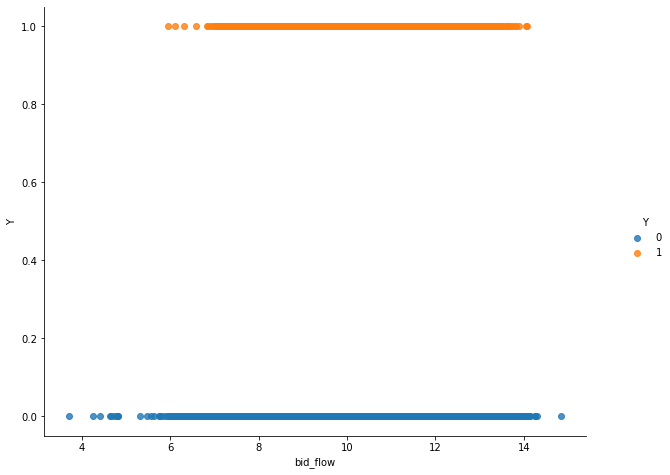

In [38]:
plot_feature('bid_flow')

In [39]:
add_feature(data['bid_flow']/data['ask_flow'], 'bid_ask_flow')

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2',
       'mom3', 'std', 'ask_flow', 'bid_flow', 'bid_ask_flow'],
      dtype='object')


In [40]:
#add_feature(abs(data['bid_flow'] - data['ask_flow'])/(data['bid_flow']  + data['ask_flow']), 'bid_ask_flow')

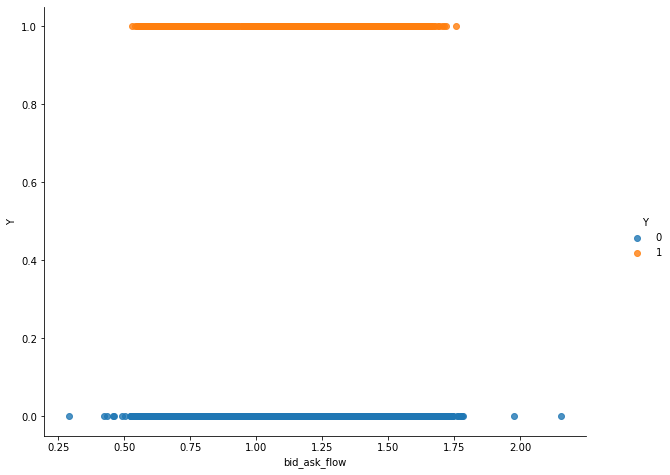

In [41]:
plot_feature('bid_ask_flow')

In [42]:
t = data[data['bid_ask_flow'] < 0.55]['Y']
sum(t)/len(t)

0.10256410256410256

In [43]:
t = data[data['bid_ask_flow'] > 1.5]['Y']
sum(t)/len(t)

0.11366384522370013

In [44]:
data[['bid_flow', 'ask_flow', 'bid_ask_flow']].corr()

,bid_flow,ask_flow,bid_ask_flow
bid_flow,1.000000,-0.428559,0.887992
ask_flow,-0.428559,1.000000,-0.784889
bid_ask_flow,0.887992,-0.784889,1.000000


In [45]:
data[['logVASK0', 'logVBID0']].corr()

,logVASK0,logVBID0
logVASK0,1.000000,-0.460094
logVBID0,-0.460094,1.000000


Часть фичей мы не будем включать из-за высокой корреляции с другими

# Model

In [46]:
#train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(0)

In [47]:
data = train_data

In [48]:
print(train_data.columns)

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'Y', 'logVASK0', 'logVBID0',
       'logASK0/ASK0_PREV', 'logBID0/BID0_PREV', 'mom0', 'mom1', 'mom2',
       'mom3', 'std', 'ask_flow', 'bid_flow', 'bid_ask_flow'],
      dtype='object')


In [49]:
data = data[[
       'Y', 'mom1', 'mom2', 'mom3',
       'ask_flow', 'bid_flow', 'std', 'logVBID0', 'logVASK0',
       'logBID0/BID0_PREV', 'logASK0/ASK0_PREV'
]]

In [50]:
data = data.fillna(0)

In [51]:
q = 0.8
X_train, X_test = data[data.columns[data.columns != 'Y']][:int(len(data)*q)], data[data.columns[data.columns != 'Y']][int(len(data)*q):]
y_train, y_test = data[data.columns[data.columns == 'Y']][:int(len(data)*q)], data[data.columns[data.columns == 'Y']][int(len(data)*q):]

In [52]:
y_train = np.array(y_train).reshape((-1, 1))
y_test = np.array(y_test).reshape((-1, 1))

In [53]:
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
x = sm.add_constant(X_train)
y = Logit(y_train, x).fit()

Optimization terminated successfully.
         Current function value: 0.043042
         Iterations 10


In [54]:
print(y.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               149272
Model:                          Logit   Df Residuals:                   149261
Method:                           MLE   Df Model:                           10
Date:                Fri, 06 Nov 2020   Pseudo R-squ.:                  0.2415
Time:                        11:34:30   Log-Likelihood:                -6425.0
converged:                       True   LL-Null:                       -8470.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.1282      0.739     -8.294      0.000      -7.576      -4.680
mom1                  0.0520      0.063      0.829      0.407      -0.071       0.175
mom2                 -0.

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
import xgboost as xgb

In [56]:
x = sm.add_constant(X_test)
y_predicted = y.predict(x)
t = []
score = []
for M in [0.0001, 0.01/4, 0.01/2, 0.01, 0.03, 0.05, 0.1, 0.13, 0.2]:
    t.append(M)
    print(confusion_matrix(y_test, y_predicted  > M)) #threshold to compare CF
    
print("#######")
print('score:', roc_auc_score(y_test, y_predicted))

[[    1 36920]
 [    0   397]]
[[13282 23639]
 [   13   384]]
[[25115 11806]
 [   31   366]]
[[31203  5718]
 [   74   323]]
[[35023  1898]
 [  174   223]]
[[35805  1116]
 [  223   174]]
[[36422   499]
 [  277   120]]
[[36600   321]
 [  306    91]]
[[36810   111]
 [  352    45]]
#######
score: 0.8977674232210827


In [57]:
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

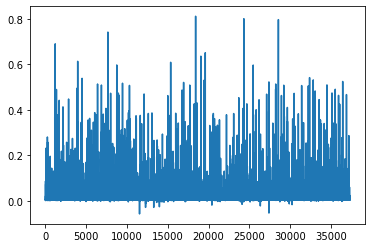

In [58]:
reg = xgb.XGBRegressor(n_estimators=2000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False,
       ) # Change verbose to True if you want to see it train


plt.plot(reg.predict(X_test))

In [59]:
y_predicted = reg.predict(X_test)
t = []
score = []
for M in [0.0001, 0.01/4, 0.01/2, 0.01, 0.03, 0.05, 0.1, 0.13, 0.2]:
    t.append(M)
    print(confusion_matrix(y_test, y_predicted  > M)) #threshold to compare CF
    
print("#######")
print('score:', roc_auc_score(y_test, y_predicted))

[[   49 36872]
 [    3   394]]
[[  106 36815]
 [    3   394]]
[[25570 11351]
 [   39   358]]
[[30989  5932]
 [   70   327]]
[[34433  2488]
 [  144   253]]
[[35593  1328]
 [  196   201]]
[[36471   450]
 [  271   126]]
[[36583   338]
 [  290   107]]
[[36741   180]
 [  320    77]]
#######
score: 0.8999905987574942


In [60]:
FI = pd.Series(reg.feature_importances_)
FI.index = list(X_train.columns)

In [61]:
FI

mom1                 0.065048
mom2                 0.068385
mom3                 0.068637
ask_flow             0.075098
bid_flow             0.089306
std                  0.089911
logVBID0             0.089319
logVASK0             0.100277
logBID0/BID0_PREV    0.173954
logASK0/ASK0_PREV    0.180065
dtype: float32

In [62]:
from catboost import CatBoostClassifier

In [63]:
model = CatBoostClassifier(iterations=500,
                           depth=1,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True, )
                          #use_best_model = True)
# train the model
model.fit(X_train, y_train, plot = False)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.0565229	total: 201ms	remaining: 1m 40s
1:	learn: 0.0540839	total: 218ms	remaining: 54.2s
2:	learn: 0.0510117	total: 236ms	remaining: 39.1s
3:	learn: 0.0496353	total: 256ms	remaining: 31.8s
4:	learn: 0.0490601	total: 273ms	remaining: 27s
5:	learn: 0.0473996	total: 293ms	remaining: 24.1s
6:	learn: 0.0469109	total: 311ms	remaining: 21.9s
7:	learn: 0.0459353	total: 330ms	remaining: 20.3s
8:	learn: 0.0457324	total: 348ms	remaining: 19s
9:	learn: 0.0452045	total: 367ms	remaining: 18s
10:	learn: 0.0451276	total: 384ms	remaining: 17.1s
11:	learn: 0.0448912	total: 402ms	remaining: 16.3s
12:	learn: 0.0447888	total: 419ms	remaining: 15.7s
13:	learn: 0.0445604	total: 436ms	remaining: 15.1s
14:	learn: 0.0444281	total: 455ms	remaining: 14.7s
15:	learn: 0.0441753	total: 473ms	remaining: 14.3s
16:	learn: 0.0440229	total: 491ms	remaining: 14s
17:	learn: 0.0439908	total: 507ms	remaining: 13.6s
18:	learn: 0.0439619	total: 524ms	remaining: 13.3s
19:	learn: 0.0437931	total: 542ms	remaining: 13s

161:	learn: 0.0411035	total: 3.17s	remaining: 6.61s
162:	learn: 0.0410978	total: 3.19s	remaining: 6.59s
163:	learn: 0.0410915	total: 3.2s	remaining: 6.56s
164:	learn: 0.0410894	total: 3.22s	remaining: 6.54s
165:	learn: 0.0410827	total: 3.24s	remaining: 6.51s
166:	learn: 0.0410793	total: 3.25s	remaining: 6.49s
167:	learn: 0.0410785	total: 3.27s	remaining: 6.47s
168:	learn: 0.0410672	total: 3.29s	remaining: 6.44s
169:	learn: 0.0410588	total: 3.31s	remaining: 6.42s
170:	learn: 0.0410569	total: 3.33s	remaining: 6.4s
171:	learn: 0.0410557	total: 3.34s	remaining: 6.38s
172:	learn: 0.0410531	total: 3.36s	remaining: 6.36s
173:	learn: 0.0410501	total: 3.38s	remaining: 6.33s
174:	learn: 0.0410471	total: 3.4s	remaining: 6.31s
175:	learn: 0.0410371	total: 3.42s	remaining: 6.29s
176:	learn: 0.0410286	total: 3.44s	remaining: 6.28s
177:	learn: 0.0410266	total: 3.46s	remaining: 6.25s
178:	learn: 0.0410238	total: 3.48s	remaining: 6.23s
179:	learn: 0.0410207	total: 3.49s	remaining: 6.21s
180:	learn: 0.0

325:	learn: 0.0406592	total: 6.28s	remaining: 3.35s
326:	learn: 0.0406586	total: 6.3s	remaining: 3.33s
327:	learn: 0.0406568	total: 6.31s	remaining: 3.31s
328:	learn: 0.0406559	total: 6.33s	remaining: 3.29s
329:	learn: 0.0406544	total: 6.35s	remaining: 3.27s
330:	learn: 0.0406539	total: 6.37s	remaining: 3.25s
331:	learn: 0.0406501	total: 6.38s	remaining: 3.23s
332:	learn: 0.0406491	total: 6.4s	remaining: 3.21s
333:	learn: 0.0406475	total: 6.42s	remaining: 3.19s
334:	learn: 0.0406464	total: 6.44s	remaining: 3.17s
335:	learn: 0.0406454	total: 6.46s	remaining: 3.15s
336:	learn: 0.0406440	total: 6.47s	remaining: 3.13s
337:	learn: 0.0406425	total: 6.49s	remaining: 3.11s
338:	learn: 0.0406416	total: 6.51s	remaining: 3.09s
339:	learn: 0.0406407	total: 6.53s	remaining: 3.07s
340:	learn: 0.0406400	total: 6.55s	remaining: 3.05s
341:	learn: 0.0406391	total: 6.57s	remaining: 3.04s
342:	learn: 0.0406387	total: 6.59s	remaining: 3.02s
343:	learn: 0.0406379	total: 6.61s	remaining: 3s
344:	learn: 0.040

491:	learn: 0.0404514	total: 9.42s	remaining: 153ms
492:	learn: 0.0404502	total: 9.44s	remaining: 134ms
493:	learn: 0.0404493	total: 9.46s	remaining: 115ms
494:	learn: 0.0404440	total: 9.48s	remaining: 95.8ms
495:	learn: 0.0404417	total: 9.5s	remaining: 76.6ms
496:	learn: 0.0404403	total: 9.52s	remaining: 57.5ms
497:	learn: 0.0404376	total: 9.54s	remaining: 38.3ms
498:	learn: 0.0404355	total: 9.55s	remaining: 19.1ms
499:	learn: 0.0404347	total: 9.57s	remaining: 0us
class =  [0 0 0 ... 0 0 0]
proba =  [[0.99872131 0.00127869]
 [0.99866368 0.00133632]
 [0.99829308 0.00170692]
 ...
 [0.99810294 0.00189706]
 [0.99569574 0.00430426]
 [0.9987115  0.0012885 ]]


In [64]:
FI = pd.Series(model.feature_importances_)
FI.index = list(X_train.columns)
FI

mom1                  0.914921
mom2                  1.712862
mom3                  1.085747
ask_flow              3.254485
bid_flow              6.087649
std                   6.937946
logVBID0             21.945003
logVASK0             23.811135
logBID0/BID0_PREV    17.772296
logASK0/ASK0_PREV    16.477955
dtype: float64

In [65]:
y_predicted = preds_proba[:, 1]
t = []
score = []
for M in [0.0001, 0.01/4, 0.01/2, 0.01, 0.03, 0.05, 0.1, 0.13, 0.2]:
    t.append(M)
    print(confusion_matrix(y_test, y_predicted  > M)) #threshold to compare CF
    
print("#######")
print('score:', roc_auc_score(y_test, y_predicted))

[[    2 36919]
 [    0   397]]
[[21672 15249]
 [   23   374]]
[[28248  8673]
 [   52   345]]
[[31500  5421]
 [   75   322]]
[[34512  2409]
 [  151   246]]
[[35384  1537]
 [  187   210]]
[[36424   497]
 [  287   110]]
[[36585   336]
 [  300    97]]
[[36754   167]
 [  327    70]]
#######
score: 0.9004124948653047


Результат: roc_auc_score  = 0.9004124948653047

In [772]:
def add_feature(feature, name):
    test_data[name] = feature
    print(test_data.columns)
    
def del_feature(name):
    del test_data[name]

In [773]:
data = test_data

In [774]:
add_feature(np.log(data['VASK0']), 'logVASK0')
add_feature(np.log(data['VBID0']), 'logVBID0')
add_feature(np.log(data['VASK0']/data['VASK0_PREV']), 'logASK0/ASK0_PREV')
add_feature(np.log(data['VBID0']/data['VBID0_PREV']), 'logBID0/BID0_PREV')
add_feature(np.log(data['VASK0']/data['VASK0_PREV']) * np.log(data['VASK1']/data['VASK0'])
            -
            np.log(data['VBID0']/data['VBID0_PREV']) * np.log(data['VBID1']/data['VBID0'])
            , 'mom1')
add_feature(np.log(data['VASK0']/data['VASK0_PREV']) * np.log(data['VASK1']/data['VASK0'])*
            np.log(data['VASK2']/data['VASK1'])*np.log(data['VASK3']/data['VASK2'])
            -
            np.log(data['VBID0']/data['VBID0_PREV']) * np.log(data['VBID1']/data['VBID0'])*
            np.log(data['VBID2']/data['VBID1'])*np.log(data['VBID3']/data['VBID2'])
            , 'mom2')
add_feature(np.log(data['VASK0']/data['VASK0_PREV']) * np.log(data['VASK1']/data['VASK0'])*
            np.log(data['VASK2']/data['VASK1'])*np.log(data['VASK3']/data['VASK2'])*
            np.log(data['VASK4']/data['VASK3'])
            
            -
            
            np.log(data['VBID0']/data['VBID0_PREV']) * np.log(data['VBID1']/data['VBID0'])*
            np.log(data['VBID2']/data['VBID1'])*np.log(data['VBID3']/data['VBID2'])*np.log(data['VBID4']/data['VBID3'])
            , 'mom3')

add_feature(np.log(data['VASK0']/data['VASK0_PREV']).rolling(2).std()
            - np.log(data['VBID0']/data['VBID0_PREV']).rolling(2).std(), 'std')

fl0 = np.log(data['VASK0']) - np.log(data[['VASK1', 'VASK2', 'VASK3', 'VASK4']].sum(axis = 1))

flbtw = (np.log(data[['VASK1', 'VASK2', 'VASK3', 'VASK4']]) - np.log((data[['VASK1_PREV', 'VASK2_PREV', 'VASK3_PREV', 'VASK4_PREV']]).shift(1))).fillna(0).sum(axis = 1)
vol= np.log(data[['VASK1', 'VASK2', 'VASK3', 'VASK4']].sum(axis = 1))
add_feature(vol + flbtw - fl0, 'ask_flow')

fl0 = np.log(data['VBID0']) - np.log(data[['VBID1', 'VBID3', 'VBID4']].sum(axis = 1))
flbt = (np.log(data[['VBID1', 'VBID2', 'VBID3', 'VBID4']]) - np.log((data[['VBID1_PREV', 'VBID2_PREV', 'VBID3_PREV', 'VBID4_PREV']]).shift(1))).fillna(0).sum(axis = 1)
vol= np.log(data[['VBID1', 'VBID2', 'VBID3', 'VBID4']].sum(axis = 1))
add_feature(vol + flbt - fl0, 'bid_flow')
#(data[['VBID1', 'VBID3', 'VBID4']] - np.log(data[['VBID1_PREV', 'VBID3_PREV', 'VBID4_PREV']].shift(1)).fillna(0).sum(axis = 1)

Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'logVASK0', 'logVBID0', 'logASK0/ASK0_PREV',
       'logBID0/BID0_PREV', 'mom1', 'mom2', 'mom3', 'std', 'ask_flow',
       'bid_flow'],
      dtype='object')
Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', 'VASK4_PREV', 'VBID0_PREV', 'VBID1_PREV', 'VBID2_PREV',
       'VBID3_PREV', 'VBID4_PREV', 'logVASK0', 'logVBID0', 'logASK0/ASK0_PREV',
       'logBID0/BID0_PREV', 'mom1', 'mom2', 'mom3', 'std', 'ask_flow',
       'bid_flow'],
      dtype='object')
Index(['VASK0', 'VASK1', 'VASK2', 'VASK3', 'VASK4', 'VBID0', 'VBID1', 'VBID2',
       'VBID3', 'VBID4', 'VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV',
       'VASK3_PREV', '

In [775]:
data = data.fillna(0)

In [776]:
x_test = data

In [777]:
data['logVASK0']

0        5.231109
1        3.610918
2        5.273000
3        1.609438
4        4.762174
           ...   
93291    4.290459
93292    3.496508
93293    4.927254
93294    4.976734
93295    4.430817
Name: logVASK0, Length: 93296, dtype: float64

In [778]:
x_test = x_test[[
    'mom1', 'mom2', 'mom3',
       'ask_flow', 'bid_flow', 'std', 'logVBID0', 'logVASK0',
       'logBID0/BID0_PREV', 'logASK0/ASK0_PREV'
]]

In [779]:
preds_class = model.predict(x_test)
preds_proba = model.predict_proba(x_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

class =  [0 0 0 ... 0 0 0]
proba =  [[9.99445165e-01 5.54835376e-04]
 [9.96609878e-01 3.39012166e-03]
 [9.97583874e-01 2.41612633e-03]
 ...
 [9.99084460e-01 9.15539951e-04]
 [9.98322051e-01 1.67794881e-03]
 [9.98228695e-01 1.77130473e-03]]


In [780]:
pd.Series(preds_proba[:, 1]).to_csv('probs.csv')